In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy

# Using discrete event simulation to help plan a vaccine clinic

Discrete event simulation (DES) is a well established technique for building simulation models of systems characterized by:

* events that happen at discrete points in time (e.g. the arrival of a patient to the vaccine clinic, the completion of the vaccine injection),
* uncertainty in the timing and duration of events (patient show up somewhat randomly even if they have a scheduled appointment, the time to register might depend on various patient characteristics),
* entities (e.g. patients) that flow through a system, 
* contention for resources (patients will wait to at various stages of their vaccine visit to wait for resources such as administrative and clinical staff to become available)
* interest in how the system is performing in terms of things like entity delays, resource utilization, or frequency of certain events.

Typical applications include building models of healtchare delivery systems, manufacturing systems, computer networks, call centers and other service systems, and many others. In all of these systems there are entities that flow (patients, widgets, packets, phone calls) and contend for resources for processing (nurses to give vaccines, machines to process, servers to accept packets, agents to answer the phone). By building a representative simulation model, we can study how such systems might perform if we changes some important entity or resource related inputs: patient arrival rate, machine processing rate, number of servers or number of agents answering calls. The applications are endless and it can be a whole lot cheaper to experiment with a computer model than to experiment with the real system.

DES models are "what if?" models that can help in predicting outputs of a system for a given set of input values. They can help statistically characterize the projected performance of the system being modeled. For example, we might simulate different assembly line configurations to get a sense of the throughput differences for different processes. Or, for a call center they could help predict the impact on customer wait time of a 25% increase in call volume. 

Back in the pcda class, we built a simple simulation model of the Monte-Hall 3-Door problem which allowed us to compare the success of different strategies such as staying with the original door selected vs switching. For that model we didn't need a specialized discrete event package since we were just modeling a sequence of events with the time between them being unimportant. Furthermore, there was no contention for resources. If you want to review that model, see the downloads and screencasts on [this page from the pcda courseweb](http://www.sba.oakland.edu/faculty/isken/courses/mis5470_w21/python_intro_2.html) (just scroll down to find info about the problem and links to the screencasts).

Ultimately, our goal in this module is to develop a DES model model of a simple vaccine clinic consisting of the following process steps:

```
Arrival --> Temperature check --> Registration --> Vaccination --> Schedule 2nd dose (if needed) --> Wait 15 minutes --> Exit
```

Our model should handle:

* uncertainty in the processing times of the individual steps above,
* uncertainty in patient arrival times
* finite numbers of different types of resources (staff)
* ability to estimate key process metrics such as patient wait times and total time in clinic as well as resource utilization.

Such a model would be quite useful in helping do capacity planning and appointment scheduling for the clinic. We need to decide how many staff are needed at each stage of the clinic visit and how much room we need in the post-vaccination patient observation area.

Let's start by learning a little about how DES software works, both in general and with respect to SimPy, the Python package we'll be using.

## Under the hood with DES software

Internally, DES software relies on the notion of a simulation clock and a next event list (the *discrete events*) to decide which event to process next and when to process it. **Between these discrete events, nothing happens to the state of the system - the clock "ticks" from event to event.** For example, here's what the next event list might look like (conceptually) at some time $t=70.1$ during the simulation.

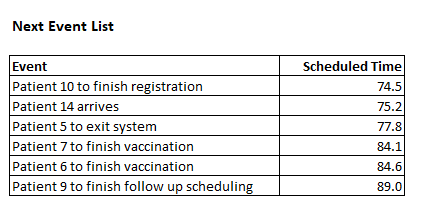

In [2]:
Image("images/next_event_list.png")

Simulation software such as SimPy does the work of maintaining this list - adding new events, processing the next event, and removing events once they've been processed. In many ways, it's like a job scheduler. When the ongoing event is done with processing, DES software will look at the next event and see that `Patient 10 to finish registration` will happen at $t=74.5$. It will:

* advance the simulation clock to $74.5$
* send a signal that this event is occurring

Our program is "listening" or "waiting to be triggered" by this event and the appropriate part of our code will then do whatever we want to do when a patient finishes the registration process. For example, we might:

* store the timestamp of when registration was completed for this patient,
* have the patient request a nurse to begin the actual vaccination,
* if the nurse is available:
    - generate a random vaccination process time and wait for that time to elapse (a new event gets added to the next event list)
* if the nurse is not available:
    - the DES software manages the internal requests for resources in some sort of queue
    
The advantage of using DES software such as SimPy is that it does the tedious work of managing the next event list and all the resource queues. 
    

### DES software
DES has a long history and there are numerous commercial packages for doing this type of simulation. Many of these are quite sophisticated and allow you to build very complex, animated models and include comprehensive statistical monitors and analysis tools. Here's are two short video clips of such a models built with Simio, a modern DES package (I created a Simio based course at OU which is now taught by Prof. Aydas.) As you can see, you can build simple, abstract models as well as very complex and realistic models.

* [A simple abstract model](https://www.youtube.com/watch?v=2_FgFgLXNm8)
* [A Simio model of a manufacturing facility](https://www.youtube.com/watch?v=rxpJN7hUTzo&list=PL43C4_Bof9vGErW6y-dRIfr-_vIEQnNkZ&index=3&t=19s)

Other popular GUI based DES tools include Arena (my course used this before Simio came along), ProModel, AnyLogic, FlexSim, SIMUL8 and many others. Here's a screenshot of a pharmacy simulation model I built for a consulting project using Arena. Well, actually, I did all of the model development but did not build the layout graphic below (my artistic skills are not nearly this good). :) This model was used to help the client make decisions related to adding robotic automation to their pharmacy. We could test out various configurations to see how they impacted patient wait times and system throughput.



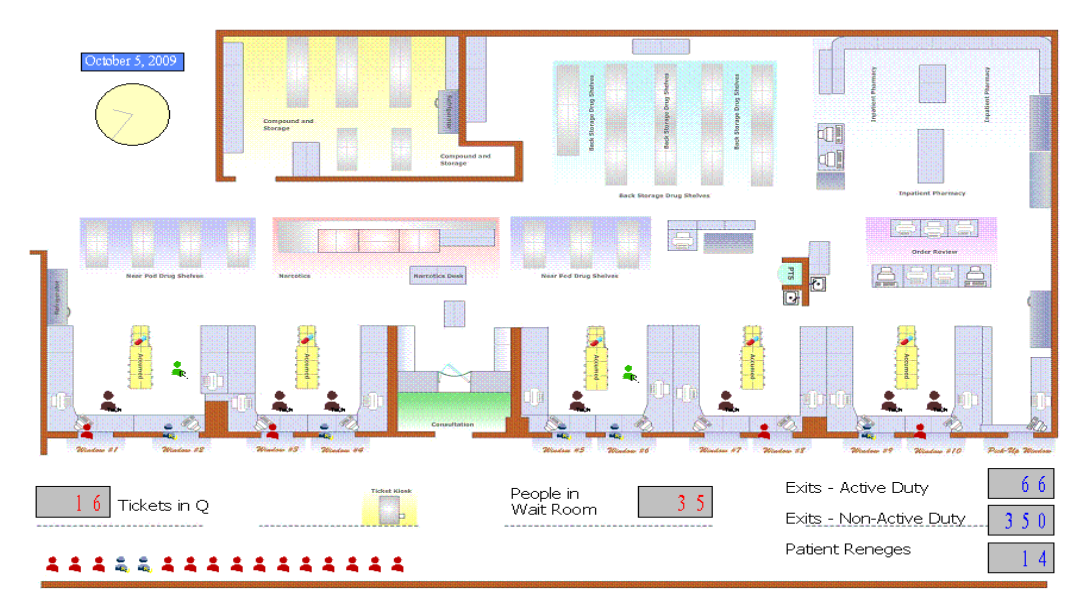

In [3]:
Image("images/pharmacy.png")

While these tools are quite powerful and the ability to create animated models is quite valuable for both model debugging, model validation and communicating with decision makers, there are some downsides:

* Some of these tools are quite expensive ($10K and up ... per license)
* Can be difficult to share models since expensive, proprietary software is needed
* While GUI tools are nice, sometimes complex logic can't easily be modeled (to be fair, most of these packages do allow some degree of interacting with programming languages such as C#, VBA, Python, Java and others.)

Another approach is to use an open source library based on a general purpose programming language such as C++, Java, or Python. Of course, quality and availability varies and using them requires programming skills. Things like animation and statistical monitors may or may not be built in. Nevertheless, they are a great way to really learn what simulation modeling is all about. And, don't let the pretty pictures and videos above fool you, underneath them is a next event list and code and data.

For this class we will learn the basics of using a library called SimPy. It's been around for a few years but it's certainly a bit of a bare bones package. But, with a little Python knowledge, real simulation models can be built.

## Getting started with SimPy

From the SimPy in 10 Minutes tutorial:

> SimPy is a discrete-event simulation library. The behavior of active components (like vehicles, customers or messages) is modeled with processes. All processes live in an environment. They interact with the environment and with each other via events.

SimPy makes it easier to build DES models with Python by taking care of things like the simulation clock and the next event list. It provides high level constructs for modeling components of your model as entities, processes and resources.

We are going to build a basic model of a vaccine clinic. It's a prototypical example in that our model should be able to handle:

* a random arrival process
* a multi-stage process in which we have to contend for limited resources at each stage,
* there is uncertainty in the processing times,
* we are interested in things like the relationship between patient volume, resource utilization and patient waiting. 

We want to build a model that will be helpful in deciding how many vaccination stations to have, the hours of operation of the vaccine clinic, and the size of the post-vaccine waiting room needed. 

Like the SimPy in 10 Minutes tutorial, I will start with the very basics and keep adding on functionality and complexity. Along the way, I'll try to give you a bit of sense of how SimPy works. Start by reading the [Basic Concepts section of the SimPyin 10 tutorial](https://simpy.readthedocs.io/en/latest/simpy_intro/basic_concepts.html#basic-concepts) to start to become familiar with some fundamental SimPy concepts:

* we model many components of our simulation with *processes*,
* all of our processes live in a SimPy *environment*,
* the processes interact with each other and the SimPy environent through *events*.

I encourage you to have a Jupyter notebook open as you are going through the SimPy in 10 Minutes tutorial and build the simple Car Simulation model it uses.

### Another really good getting started tutorial
I also highly recommend the following tutorial from Real Python. It walks you through building a simulation model a movie theater. It's very well done and will help you better understand both the big picture of DES modeling and SimPy.

* https://realpython.com/simpy-simulating-with-python/

In the downloads file, I have included the `theater_simulate.py` file that goes along with this tutorial.

### Digging a little deeper into the inner workings of SimPy

If interested, see https://simpy.readthedocs.io/en/latest/topical_guides/simpy_basics.html#how-simpy-works for more technical details on how SimPy works.



## Prelude: Generators

The way that SimPy enables event based modeling is through Python *generators*. Generators are a special type of function (or method) that acts as an iterator and that remembers its state between calls to it. We also say that generator functions are *lazy iterators*.  They are lazy in the sense that they don't generate their values until asked to do so. For example, consider using a list comprehension to generate the first 10 perfect squares.

In [4]:
squares = [x ** 2 for x in range(1, 11)]
print(squares)

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]


Now, I'll replace the brackets in the above list comprehension with parentheses - now it's something called a *generator expression*. It creates an iterator (something we can call `next` on to get the next value in the sequence), but doesn't actually generate the values until asked.

In [5]:
perfect_squares_gen_1 = (x ** 2 for x in range(1, 11))
print(perfect_squares_gen_1)

<generator object <genexpr> at 0x00000174C7F94748>


In [6]:
for _ in range(10):
    print(next(perfect_squares_gen_1))

1
4
9
16
25
36
49
64
81
100


Wait, what does this have to do with simulation? Let's back up and reconsider that previous example. What if we wanted a function that could generate an infinite sequence of perfect squares? Obviously, we can't just generate a list of an infinite number of perfect squares. Generator functions provide a way to do such things, and they do it by remembering their internal state. For example:

In [7]:
def perfect_squares_gen_2():
    value = 0
    while True:
        value += 1
        yield value ** 2

In [8]:
perfect_squares = perfect_squares_gen_2()
print(next(perfect_squares))
print(next(perfect_squares))
print(next(perfect_squares))

1
4
9


The key is noticing the `yield` keyword. It serves to return a value from our generator function `perfect_square_gen` (much like a standard `return` statement) but **ALSO** remembers the value of `value`, a local variable in the function. It also, temporarily, passes control back to whomever called. Since it can remember its `state`, it knows where it left off whenever the function is called again using `next`. No need to generate new values until asked. You might have realized that `perfect_squares_gen_1` is really just some syntactic sugar for doing what we did in `perfect_squares_gen_2`.

Now let's consider something a little more relevant to simulation modeling. We rely on SimPy to provide an manage a *simulation clock*. Let's create our own simple clock in Python. However, unlike a normal clock, we tell the clock how large of a "tick" it should make every time we ask it for the time. It should start time time `t = 0` and then be incremented by whatever tick size we pass into it.

In [9]:
def simple_event_clock(tick_size):
    t = 0
    while True:
        print(f"The time was {t} and you asked me to tick {tick_size} time units.")
        t += tick_size
        yield t

In [10]:
clock = simple_event_clock(5)
print(next(clock))
print(next(clock))
print(next(clock))

The time was 0 and you asked me to tick 5 time units.
5
The time was 5 and you asked me to tick 5 time units.
10
The time was 10 and you asked me to tick 5 time units.
15


The big takeaway is that by using `yield`, we can have a function that kind of goes into "suspended animation" but can pick up where it left off when it's asked to. In SimPy, we will have *process functions* that create events and then `yield` them and wait for the event to be triggered. The most common such event is a `Timeout` event - it gets triggered when a specified duration of time has passed on the simulation clock. A `Timeout` event could be used to model something like the time it takes for a patient to get registered at our clinic. We will also use `yield` when we need to acquire a resource such as the clinician who will vaccinate the patient. Since we have a finite number of clinicians, the patient may have to wait until one becomes available. 

Some additional resources on generators include:

* https://dbader.org/blog/python-generators
* https://realpython.com/introduction-to-python-generators/

## The structure of a SimPy program

There are actually several different ways to structure a SimPy simulation model program. You can do things in an object-oriented fashion, or a more procedural way, or a combination of both. Within these choices there are many different ways to go about developing the details of the model. Even though SimPy has been around for several years, best practices for modeling are still evolving. In addition, things that come as standard features in many commercial simulation packages such as statistical monitoring and animation, are the responsibility of the modeler when using SimPy. This can affect how the model is architected. 

In this tutorial, I'm going to try to use a pattern that is easily accessible by new Python simulation modelers. It will use a combination of custom classes as well as process functions.

Before launching into building the entire vaccine clinic model, let's do a few simple warmup models to become more familiar with SimPy.

## Model 1: Creating a patient arrival process

For our vaccine clinic model, we'll need a way to generate patient arrivals. To start, let's just generate a new patient every $n$ minutes. There are no specific time units specified in SimPy. It's our job to keep our time units straight and is helpful to think of each unit of time as a minute. It would be nice to know when each patient was created to make sure things are working correctly. SimPy has functions for accessing the state of the simulation clock - the current simulation time is accessible from the `now` attribute of the simulation environment object (which by convention we usually name `env`). We'll include `print` statements to help illustrate what is going in inside the function.

In [11]:
def patient_arrivals(env, interarrival_time=5.0):
    """Generate patients according to a fixed time arrival process"""

    # Create a counter to keep track of number of patients generated and to serve as unique patient id
    patient = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time (this will be more complicated later)
        iat = interarrival_time
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Okay, we're back. :) New patient generated = update counter of patients
        patient += 1
        
        print(f"Patient {patient} created at time {env.now}")



Now we can create a simple simulation model that just generates patients for some fixed amount of time.

**IMPORTANT THING TO NOTE** 

In the code below, you'll see the following line:

```python
env1.process(patient_arrivals(env1, interarrival_time))
```

This is really doing two things:

1. The `patient_arrivals(env1, interarrival_time)` part is calling the `patient_arrivals` generator function and gets back a Python generator.
2. The `env1.process()` part is then *registering* this generator with the simulation environment (`env1` in this example).

In fact, I could have written the above in two lines, one line per step listed above:

```python
arrival_generator = patient_arrivals(env1, interarrival_time)
env1.process(arrival_generator)
```

For any generator function you write (i.e. any function that contains a `yield` statement, you **MUST** register it with the simulation enironment by passing the generator with the `process` function. 

In [12]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the patient_arrivals process and adds it to the environment
runtime = 25
interarrival_time = 3.0
env1.process(patient_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Patient 1 created at time 3.0
Patient 2 created at time 6.0
Patient 3 created at time 9.0
Patient 4 created at time 12.0
Patient 5 created at time 15.0
Patient 6 created at time 18.0
Patient 7 created at time 21.0
Patient 8 created at time 24.0


From a modeling perspective, patients arriving at perfectly equally spaced interarrival times is pretty unrealistic. If we were modeling a "walk-in clinic" in which no patients have scheduled appointments, it would be more appropriate to model patient arrivals by something known as a *Poisson arrival process*. These processes are characterized by:

* a constant mean arrival rate (usually denoted by $\lambda$).
* the time between invidual arrivals is exponentially distributed
* arrivals are independent of each other
* the number of arrivals is any time interval of length $t$, is Poisson distributed with mean $\lambda t$

Poisson process are commonly used to model things like calls to call centers, arrivals of patients to an emergency room, and even things like hurricanes. A really nice basic intro is available in the following blog post:

* https://towardsdatascience.com/the-poisson-distribution-and-poisson-process-explained-4e2cb17d459

Since Poisson arrival processes have interarrival times that are exponentially distributed, we need to generate exponential random variates within our `patient_arrivals` function. For this, we'll use numpy. Recently, numpy has updated their random variable generation routines - details are at https://numpy.org/doc/stable/reference/random/index.html.

First we need to import the default random number generator and create a random generator variable. I'll use 4470 as the seed. This generator generates numbers uniformly between 0 and 1, which can be used to generate random variates from whatever distribution we choose.

In [13]:
from numpy.random import default_rng
rg = default_rng(seed=4470)
rg.random() # This is kind of like rand() in Excel except that we get to control the generator via a seed value.

0.45855804438027437

In addition to generating random numbers, it's handy to have a way to compute various quantities of probability distributions. The `scipy.stat`s module contains a large number of probability distributions and each has numerous functions for calculating things such as pdf or CDF values, quantiles, and various moments. You can see the details at https://docs.scipy.org/doc/scipy/reference/stats.html. We'll use it here to overlay the exponential pdf on our histrogram of generated exponential random variates.

In [14]:
from scipy.stats import expon
mean_interarrival_time = interarrival_time
rv_expon = expon(scale=mean_interarrival_time)

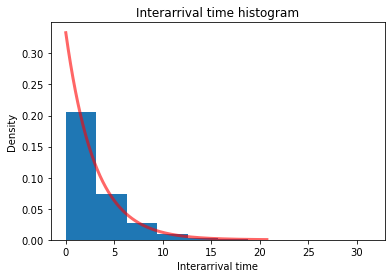

In [15]:
# Generate 1000 exponential random variates
iat_sample = rg.exponential(mean_interarrival_time, 10000)

# Create a histogram of the random samples with exponential pdf overlaid
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

# Create values for the x-axis
x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

# Create values for the y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf,
       'r-', lw=3, alpha=0.6, label='Exponential pdf');



Now, we'll modify our patient arrivals function to use Poisson arrivals instead of equally-spaced deterministic arrivals.

In [16]:
def patient_arrivals_random_1(env, mean_interarrival_time=5.0, rg=default_rng(0)):
    """Generate patients according to a Poisson arrival process"""

    # Create a counter to keep track of number of patients generated and to serve as unique patient id
    patient = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time 
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of patients
        patient += 1
        
        print(f"Patient {patient} created at time {env.now}")



Now we'll create a new simulation environment and run this new arrival model. You'll see that the arrivals are not equally spaced.

In [17]:
# Initialize a simulation environment
env2 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env
runtime = 25
interarrival_time = 3.0
env2.process(patient_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Patient 1 created at time 2.039795711906729
Patient 2 created at time 5.098587016304323
Patient 3 created at time 5.158007004071489
Patient 4 created at time 5.164814984115174
Patient 5 created at time 6.815843602032318
Patient 6 created at time 11.705664906007474
Patient 7 created at time 13.72641376400917
Patient 8 created at time 15.992317837485343
Patient 9 created at time 24.44267577471252


## Model 2: Adding a simple delay process

Let's extend the model a bit by adding a simple delay process. In other words, let's pretend that after a patient arrives, the patient spends a random amount of time to go through all the stages of the vaccination process. In other words we are **grossly oversimplifying the real system** by ignoring all the details of the vaccination process. Let's model this total time in the vaccination clinic with another exponential distribution having a mean of 25 minutes.

To do this, we'll do two main things:

* Create a new process function for the delay process
* Modify the arrival process to create a delay event for each patient arrival



In [18]:
def delay_process(env, name, delay_time):
    """Process function modeling how a patient flows through system."""

    # Note how we are simply modeling the entire clinic visit as a delay. There
    # is NO contention for any resources.

    print(f"{name} entering vaccination clinic at {env.now:.4f}")
    
    # Yield for the delay_time
    yield env.timeout(delay_time)
    
    # The delay is over, we would exit the clinic
    print(f"{name} exiting vaccination clinic at {env.now:.4f}")

Now we can modify our arrival function to interact with our new delay process function. Notice since `delay_process` does a `yield` it **is** a Python generator function and, from SimPy's perspective, it's something we need to *register* as a `process`. We'll do this in our new arrivals function.

In [19]:
def patient_arrivals_random_2(env, mean_interarrival_time=5.0, mean_delay_time=25.0, rg=default_rng(0)):
    """Generate patients according to a Poisson arrival process"""

    # Create a counter to keep track of number of patients generated and to serve as unique patient id
    patient = 0

    # Infinite loop for generating patients
    while True:

        # Generate next interarrival time
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of patients
        patient += 1

        print(f"Patient{patient} created at time {env.now}")
        
        # Generate a random delay time from an exponential distribution
        delay_time = rg.exponential(mean_delay_time)
        
        # Create and register the delay process - I'm doing in two steps here, but could combine into one
        
        # Create a new patient delay process generator object.
        patient_visit = delay_process(env, 'Patient{}'.format(patient), delay_time)
        # Register the process with the simulation environment
        env.process(patient_visit)
        
        # Here's the one step version
        # env.process(delay_process(env, 'Patient{}'.format(patients_created), delay_time))
        

Ready to create a new simulation environment and run our new model.

In [20]:
# Initialize a simulation environment
env3 = simpy.Environment()

# Set input values
mean_interarrival_time = 3.0
mean_delay_time = 25.0

# Register our new arrivals process
env3.process(patient_arrivals_random_2(env3, mean_interarrival_time, mean_delay_time))

# Run the simulation
runtime = 25
env3.run(until=runtime)

Patient1 created at time 2.039795711906729
Patient1 entering vaccination clinic at 2.0398
Patient2 created at time 2.099215699673895
Patient2 entering vaccination clinic at 2.0992
Patient2 exiting vaccination clinic at 2.1559
Patient3 created at time 3.7502443175910396
Patient3 entering vaccination clinic at 3.7502
Patient4 created at time 5.770993175592736
Patient4 entering vaccination clinic at 5.7710
Patient5 created at time 14.221351112819914
Patient5 entering vaccination clinic at 14.2214
Patient6 created at time 24.080635886501145
Patient6 entering vaccination clinic at 24.0806
Patient6 exiting vaccination clinic at 24.1128
Patient4 exiting vaccination clinic at 24.6535


Now that you've got a little better idea of how to go about creating very simple SimPy models, let's tackle the vaccine clinic model. Again, for our first version, we'll make a number of simplifying assumptions and simplifying software design decisions. Later versions will be better.

## Model 3: The vaccine clinic model - version 0.01

Here's the basic vaccination process we'll model.

    Arrival --> Temperature check --> Registration --> Vaccination --> Schedule dose 2 (if needed) --> Wait 15 min --> Exit

### Creating a `VaccineClinic` class
We will model the clinic itself with a Python class. This class will contain attributes such as:

* the SimPy environment,
* resource capacity related inputs,
* data structures to store data collected as patients flow through the system,
* the SimPy resources for modeling the various types of staff modeled,
* process methods corresponding to processing times in each stage in the clinic patient flow diagram.

By having a `VaccineClinic` class, it makes it easy to encapsulate a bunch of input parameters, such as the capacity levels of the different staff resources, into an object that we can then pass along to other functions. This basic strategy of creating custom classes for distinct components in your simulation model is often quite useful. In a subsequent version of this model that we'll see later, we'll also have a `PatientFlow` class that will include things like the patient arrival rate and processing time parameters as attributes. Again, we'll be able to pass patient flow objects created from this class to other functions in our simulation model. 

For now, notice that the process methods corresponding to each state of the vaccination process have hard coded parameters in this class. Yes, this is bad. But it's perfectly fine to make such simplifications while you are learning and trying to get a model working. We'll improve upon this in a later version. 

In [21]:
class VaccineClinic(object):
    def __init__(self, env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg):
        # Simulation environment
        self.env = env
        
        # Create list to hold timestamps dictionaries (one per patient)
        self.timestamps_list = []
        # Create lists to hold occupancy tuples (time, occ)
        self.postvac_occupancy_list = [(0.0, 0.0)]
        self.vac_occupancy_list = [(0.0, 0.0)]
        
        # Create resources
        self.greeter = simpy.Resource(env, num_greeters)
        self.reg_staff = simpy.Resource(env, num_reg_staff)
        self.vaccinator = simpy.Resource(env, num_vaccinators)
        self.scheduler = simpy.Resource(env, num_schedulers)

    # Create process methods - hard coding processing time distributions for now
    # TODO - remove hard coding
    # The patient argument is just a unique integer number
    def temperature_check(self, patient, rg):
        yield self.env.timeout(rg.normal(0.25, 0.05))

    def registration(self, patient, rg):
        yield self.env.timeout(rg.exponential(1.0))

    def vaccinate(self, patient, rg):
        yield self.env.timeout(rg.normal(4.0, 0.5))
        
    def schedule_dose_2(self, patient, rg):
        yield self.env.timeout(rg.normal(1.0, 0.25))
    
    # We assume all patients wait at least 15 minutes post-vaccination
    # Some will choose to wait longer. This is the time beyond 15 minutes
    # that patients wait.
    def wait_gt_15(self, patient, rg):
        yield self.env.timeout(rg.exponential(0.5))

### The `get_vaccinated` function

Now we'll create a general `get_vaccinated` function to define the sequence of steps traversed by patients. We'll also capture a bunch of timestamps to make it easy to compute various system performance measures such as patient waiting times, queue sizes and resource utilization. The inputs to this function include:

* the simulation environment,
* a patient id,
* the clinic object (created from `VaccineClinic` class),
* the percentage of patients that are there for their first dose,
* the random number generator.

#### Acquiring and releasing resources

For each step in the vaccination process, you'll find a sequence of code blocks in which we:

* attempt to acquire a certain type of staff resource, 
* once we acquire the resource we get processed by calling the appropriate method of the `VaccineClinic` object, 
* we release the resource.

```python
# Request reg staff to get registered
with clinic.reg_staff.request() as request:
    yield request
    got_reg_ts = env.now
    yield env.process(clinic.registration(patient, rg))
    release_reg_ts = env.now
```

A few important points about the example above:

* `request` is a type of SimPy event corresponding to our request to get one unit of the `reg_staff` resource,
* We `yield` the `request` - in essence, suspending the function until the request can be satistfied,
* once the request is satisfied, the next line, `got_reg_ts = env.now` gets executed and we get the current simulation time and store it in a local variable, `got_reg_ts` (later in the code we'll put this variable value into a dictionary that we persists throughout the entire simulation)
* Now we do another `yield` but this time we are yielding a new `process` event, the actual `registration` (generator) function, which is part of the `clinic` object.
* When the patient is done with the registration process, the next line, `release_reg_ts = env.now`, captures the registration finish time.

We'll use this same code *pattern* throughout the `get_vaccinated` function as we move through the different stages of the vaccination process.

#### Patient flow timestamps

You just saw that we create numerous timestamp variables corresponding to things like when a patient starts and ends various stages of the vaccination process. For example:

```python
got_greeter_ts = env.now
```

Our goal is to be able to compute important durations such as how long each patient waited before starting vaccination or before registration. As long as we gather the necessary timestamps, we can compute an durations we want. At the end of the function you'll see that all of the timestamps are gathered up into a dictionary along with the patient id number and the dictionary stored in `timestamps_list`, an attribute of the clinic object.

When the simulation is done, we can convert this list of dictionaries into a pandas dataframe, compute the important time durations for each patient and then do summary stats and plots on these new fields.

#### Logging occupancy changes
We are also interested in the number of patients present in the vaccination stage and the number in the post-vaccination observation stage. Unfortunately, SimPy no longer has built in *monitor* classes to track these things. So, we'll do it ourselves. In order to correctly compute time averaged occupancy statistics, we just need to log the time and occupancy level each time it changes. For example, when a patient acquires a staff member to administer the vaccination, the occupancy in the vaccination stage increases by 1. When the vaccination is complete and the patient releases the resource, the occupancy decreases by 1.

If you look back at the `VaccineClinic` class definition, you'll see the initialization for the occupancy lists that we'll updating.

```python
self.vac_occupancy_list = [(0.0, 0.0)]
```

The `vac_occupancy_list` attribute is a list of tuples - (timestamp, occupancy). When the simulation begins, at time 0, there are 0 patients in the vaccination stage. Let's say that at time 4.5, the first patient starts the vaccination step and the second patient starts at 4.7. Here's how our `vac_occupancy_list` is changing 

```python
# At time 4.5
self.vac_occupancy_list = [(0.0, 0.0), (4.5, 1)]
# At time 4.7
self.vac_occupancy_list = [(0.0, 0.0), (4.5, 1), (4.7, 2)]
```

Now assume that one of the patients is done with the vaccination step at time 12.6.

```python
# At time 12.6
self.vac_occupancy_list = [(0.0, 0.0), (4.5, 1), (4.7, 2), (12.6, 1)]
```

When the simulation is done, we'll convert the lists of tuples into a pandas dataframe and then do the appropriate statistical analysis to compute things like the mean and 95th percentile of occupancy in these two areas. Such statistics are useful for capacity planning.



In [22]:
def get_vaccinated(env, patient, clinic, pct_first_dose, rg):
    # Patient arrives to clinic - note the arrival time
    arrival_ts = env.now

    # Request a greeter for temperature check
    # By using request() in a context manager, we'll automatically release the resource when done
    with clinic.greeter.request() as request:
        yield request
        # Now that we have a greeter, check temperature. Note time.
        got_greeter_ts = env.now
        yield env.process(clinic.temperature_check(patient, rg))
        release_greeter_ts = env.now

    # Request reg staff to get registered
    with clinic.reg_staff.request() as request:
        yield request
        got_reg_ts = env.now
        yield env.process(clinic.registration(patient, rg))
        release_reg_ts = env.now
        
    # Request clinical staff to get vaccinated
    with clinic.vaccinator.request() as request:
        yield request
        got_vaccinator_ts = env.now
        # Update vac occupancy - increment by 1
        prev_occ = clinic.vac_occupancy_list[-1][1]
        new_occ = (env.now, prev_occ + 1)
        clinic.vac_occupancy_list.append(new_occ)
        yield env.process(clinic.vaccinate(patient, rg))
        release_vaccinator_ts = env.now
        # Update vac occupancy - decrement by 1 - more compact code
        clinic.vac_occupancy_list.append((env.now, clinic.vac_occupancy_list[-1][1] - 1))
        
        # Update postvac occupancy - increment by 1
        clinic.postvac_occupancy_list.append((env.now, clinic.postvac_occupancy_list[-1][1] + 1))

    # Request scheduler to schedule second dose if needed
    if rg.random() < pct_first_dose:
        with clinic.scheduler.request() as request:
            yield request
            got_scheduler_ts = env.now
            yield env.process(clinic.schedule_dose_2(patient, rg))
            release_scheduler_ts = env.now
    else:
        got_scheduler_ts = pd.NA
        release_scheduler_ts = pd.NA
        
    # Wait at least 15 minutes from time we finished getting vaccinated 
    post_vac_time = env.now - release_vaccinator_ts
    if post_vac_time < 15:
        # Wait until 15 total minutes post vac
        yield env.timeout(15 - post_vac_time)
        # Wait random amount beyond 15 minutes
        yield env.process(clinic.wait_gt_15(patient, rg))
        exit_system_ts = env.now
        
        # Update postvac occupancy - decrement by 1
        clinic.postvac_occupancy_list.append((env.now, clinic.postvac_occupancy_list[-1][1] - 1))
    
    exit_system_ts = env.now    
    print(f"Patient {patient} exited at time {env.now}")

    # Create dictionary of timestamps
    timestamps = {'patient_id': patient,
                  'arrival_ts': arrival_ts,
                  'got_greeter_ts': got_greeter_ts,
                  'release_greeter_ts': release_greeter_ts,
                  'got_reg_ts': got_reg_ts,
                  'release_reg_ts': release_reg_ts,
                  'got_vaccinator_ts': got_vaccinator_ts,
                  'release_vaccinator_ts': release_vaccinator_ts,
                  'got_scheduler_ts': got_scheduler_ts,
                  'release_scheduler_ts': release_scheduler_ts,
                  'exit_system_ts': exit_system_ts}
    
    clinic.timestamps_list.append(timestamps)

### The `run_clinic` function
Now we'll create a function that runs the clinic for a specified number of hours. The inputs to this function include:

* the simulation environment,
* the clinic object,
* the mean patient interarrival time,
* the percentage of patients that are there for their first dose,
* the random number generator,
* stopping conditions for the simulation through either a stop time and a maximum number of patient arrivals.

Again, notice that since this function contains a `yield` statement, it is a generator and will need to be registered with the simulation environment (which we'll do from our main calling program).

In [23]:
def run_clinic(env, clinic, mean_interarrival_time, pct_first_dose, rg, 
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
      
    # Create a counter to keep track of number of patients generated and to serve as unique patient id
    patient = 0

    # Loop for generating patients
    while env.now < stoptime and patient < max_arrivals:

        # Generate next interarrival time (this will be more complicated later)
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New patient generated = update counter of patients
        patient += 1
        
        print(f"Patient {patient} created at time {env.now}")

        env.process(get_vaccinated(env, patient, clinic, pct_first_dose, rg))
        


Finally, we will create a `main` function that will serve as the entry point to using the simulation. For now, just think of it as the first function we'll call to launch the simulation. Later we'll see how we can use this function from a command line interface (CLI) to our simulation model.

In [32]:
def main():
    
    # For now we are hard coding the patient arrival rate (patients per hour)
    patients_per_hour = 180
    mean_interarrival_time = 1.0 / (patients_per_hour / 60.0)
    pct_first_dose = 0.50
    
    # Create a random number generator
    rg = default_rng(seed=4470)
    
    # For now we are going to hard code in the resource capacity levels 
    num_greeters = 2
    num_reg_staff = 2
    num_vaccinators = 12
    num_schedulers = 2
    
    # Hours of operation
    stoptime = 600 # No more arrivals after this time
    
    # Create a simulation environment
    env = simpy.Environment()
    # Create a clinic to simulate
    clinic = VaccineClinic(env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg)
    
    # Register the run_clinic (generator) function
    env.process(run_clinic(env, clinic, mean_interarrival_time, pct_first_dose, rg, stoptime=stoptime))
    # Actually run the simulation
    env.run()
    
    # The simulation is over now, let's create the output csv files from 
    # the dataframes created by running the simulation model.
    
    # Output log files 
    clinic_patient_log_df = pd.DataFrame(clinic.timestamps_list)
    clinic_patient_log_df.to_csv('./output/clinic_patient_log_df.csv', index=False)
    
    vac_occupancy_df = pd.DataFrame(clinic.vac_occupancy_list, columns=['ts', 'occ'])
    vac_occupancy_df.to_csv('./output/vac_occupancy_df.csv', index=False)
    
    postvac_occupancy_df = pd.DataFrame(clinic.postvac_occupancy_list, columns=['ts', 'occ'])
    postvac_occupancy_df.to_csv('./output/postvac_occupancy_df.csv', index=False)
    
    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)





Alright, let's run this thing!

In [33]:
clinic_end_time = main()


Patient 1 created at time 0.2591639414634509
Patient 2 created at time 0.2883726236719546
Patient 3 created at time 0.4102866904979777
Patient 4 created at time 0.7177108166650722
Patient 5 created at time 0.7737418635168912
Patient 6 created at time 1.3992151023745052
Patient 7 created at time 1.6299047861060583
Patient 8 created at time 2.166162360003664
Patient 9 created at time 3.0465673833976563
Patient 10 created at time 3.4559701673933505
Patient 11 created at time 3.759270755487417
Patient 12 created at time 5.031326677673247
Patient 13 created at time 5.265421441557918
Patient 14 created at time 5.882919003527275
Patient 15 created at time 6.018969778437991
Patient 16 created at time 6.082299905036197
Patient 17 created at time 6.491673890471963
Patient 18 created at time 7.056517634280271
Patient 19 created at time 7.390338438645231
Patient 20 created at time 7.63945262028251
Patient 21 created at time 7.993838534278838
Patient 22 created at time 8.310160554271558
Patient 23 

In [34]:
clinic_end_time

875.4387606496971

Oh, oh. The clinic ran several hours past it's intended ending time of 10 hours (600 minutes). Let's dig into the output files and figure out how to make this clinic run better.

### Post-processing the timestamps file

Our simulation model captured numerous timestamps for each patient as they went through the vaccination process. The timestamps were written to a log file with one row per patient. Now we can compute various wait times and service times for each patient and then summarize them for the clinic.

In [35]:
clinic_patient_log_df = pd.read_csv('./output/clinic_patient_log_df.csv')
clinic_patient_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             1795 non-null   int64  
 1   arrival_ts             1795 non-null   float64
 2   got_greeter_ts         1795 non-null   float64
 3   release_greeter_ts     1795 non-null   float64
 4   got_reg_ts             1795 non-null   float64
 5   release_reg_ts         1795 non-null   float64
 6   got_vaccinator_ts      1795 non-null   float64
 7   release_vaccinator_ts  1795 non-null   float64
 8   got_scheduler_ts       871 non-null    float64
 9   release_scheduler_ts   871 non-null    float64
 10  exit_system_ts         1795 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 154.4 KB


From these timestamps, it's easy to compute any duration of interest as the difference between two timestampls. For example, the total time in the system is just the `exit_system_ts` minus the `arrival_ts`.

In [36]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_greeter'] = timestamp_df.loc[:, 'got_greeter_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['wait_for_reg'] = timestamp_df.loc[:, 'got_reg_ts'] - timestamp_df.loc[:, 'release_greeter_ts']
    timestamp_df['wait_for_vaccinator'] = timestamp_df.loc[:, 'got_vaccinator_ts'] - timestamp_df.loc[:, 'release_reg_ts']
    timestamp_df['vaccination_time'] = timestamp_df.loc[:, 'release_vaccinator_ts'] - timestamp_df.loc[:, 'got_vaccinator_ts']
    timestamp_df['wait_for_scheduler'] = timestamp_df.loc[:, 'got_scheduler_ts'] - timestamp_df.loc[:, 'release_vaccinator_ts']
    timestamp_df['post_vacc_time'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'release_vaccinator_ts']
    timestamp_df['time_in_system'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

In [37]:
clinic_patient_log_df = compute_durations(clinic_patient_log_df)
clinic_patient_log_df

,patient_id,arrival_ts,got_greeter_ts,release_greeter_ts,got_reg_ts,release_reg_ts,got_vaccinator_ts,release_vaccinator_ts,got_scheduler_ts,release_scheduler_ts,exit_system_ts,wait_for_greeter,wait_for_reg,wait_for_vaccinator,vaccination_time,wait_for_scheduler,post_vacc_time,time_in_system
0,4,0.717711,0.717711,0.939134,1.734766,2.294436,2.294436,5.698411,5.698411,6.549541,21.053885,0.000000,0.795632,0.0,3.403975,0.000000,15.355474,20.336174
1,6,1.399215,1.399215,1.622652,2.294436,2.362507,2.362507,6.046302,6.046302,7.341951,21.057118,0.000000,0.671784,0.0,3.683794,0.000000,15.010816,19.657903
2,2,0.288373,0.288373,0.565944,0.565944,1.484153,1.484153,6.052770,6.549541,7.418184,21.214928,0.000000,0.000000,0.0,4.568617,0.496770,15.162158,20.926556
3,3,0.410287,0.434629,0.763368,1.484153,1.734766,1.734766,6.379838,7.418184,8.711152,22.012266,0.024342,0.720784,0.0,4.645072,1.038346,15.632428,21.601979
4,1,0.259164,0.259164,0.434629,0.434629,1.910158,1.910158,6.357624,7.341951,8.590679,22.014115,0.000000,0.000000,0.0,4.447467,0.984327,15.656491,21.754951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,1794,599.571397,599.621665,599.890359,853.968054,854.210189,854.210189,858.397241,858.397241,859.260572,873.405911,0.050268,254.077695,0.0,4.187052,0.000000,15.008670,273.834514
1791,1788,597.674139,597.674139,597.837394,850.057965,853.043204,853.043204,856.690619,NaN,NaN,874.055316,0.000000,252.220571,0.0,3.647416,NaN,17.364696,276.381177
1792,1792,599.352287,599.352287,599.621665,853.349500,853.968054,853.968054,857.884302,857.884302,859.154074,874.864149,0.000000,253.727834,0.0,3.916247,0.000000,16.979847,275.511863
1793,1793,599.413497,599.514806,599.682196,853.753272,854.661368,854.661368,859.245274,NaN,NaN,874.877901,0.101309,254.071076,0.0,4.583905,NaN,15.632628,275.464405


### Histgram of total time in system

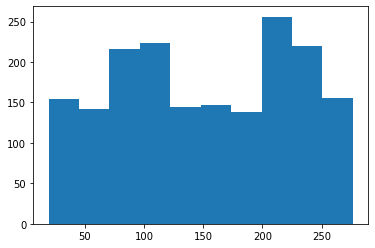

In [38]:
plt.hist(clinic_patient_log_df['time_in_system']);

Wow, some patients are spending close to five hours in the clinic!

### Key summary stats
Let's look at the wait times for each stage of the process.

In [42]:
clinic_patient_log_df.loc[:, ['wait_for_greeter', 'wait_for_reg',
                              'wait_for_scheduler', 'wait_for_vaccinator', 'time_in_system']].describe()


,wait_for_greeter,wait_for_reg,wait_for_scheduler,wait_for_vaccinator,time_in_system
count,1795.000000,1795.000000,871.000000,1795.000000,1795.000000
mean,0.025998,129.663089,0.179059,0.147750,150.574948
std,0.066186,72.980450,0.340598,0.423286,73.001200
min,0.000000,0.000000,0.000000,0.000000,19.277677
25%,0.000000,63.018129,0.000000,0.000000,83.709162
50%,0.000000,128.710459,0.000000,0.000000,149.288585
75%,0.000000,196.835437,0.227505,0.000000,217.463601
max,0.448619,254.077695,2.002851,3.424977,276.381177


Looks like registration is definitely a bottleneck. We should try increasing the number of registration staff and rerunning the model. Of course, the bottleneck can move, but we can keep repeating this process and come up with a workable capacity plan. We'll do this with a later version of the model that's implemented as a Python script. It will be much more convenient to try out different scenarios in that way.

For now, let's just copy our `main` function and increase the capacity levels quite high (to basically eliminate waiting).

In [57]:
def main():
    
    # For now we are hard coding the patient arrival rate (patients per hour)
    patients_per_hour = 180
    mean_interarrival_time = 1.0 / (patients_per_hour / 60.0)
    pct_first_dose = 0.50
    
    # Create a random number generator
    rg = default_rng(seed=4470)
    
    # For now we are going to hard code in the resource capacity levels
    # 
    num_greeters = 5
    num_reg_staff = 5
    num_vaccinators = 15
    num_schedulers = 5
    
    # Hours of operation
    stoptime = 600 # No more arrivals after this time
    
    # Create a simulation environment
    env = simpy.Environment()
    # Create a clinic to simulate
    clinic = VaccineClinic(env, num_greeters, num_reg_staff, num_vaccinators, num_schedulers, rg)
    
    # Register the run_clinic (generator) function
    env.process(run_clinic(env, clinic, mean_interarrival_time, pct_first_dose, rg, stoptime=stoptime))
    # Actually run the simulation
    env.run()
    
    # The simulation is over now, let's create the output csv files from 
    # the dataframes created by running the simulation model.
    
    # Output log files 
    clinic_patient_log_df = pd.DataFrame(clinic.timestamps_list)
    clinic_patient_log_df.to_csv('./output/clinic_patient_log_df.csv', index=False)
    
    vac_occupancy_df = pd.DataFrame(clinic.vac_occupancy_list, columns=['ts', 'occ'])
    vac_occupancy_df.to_csv('./output/vac_occupancy_df.csv', index=False)
    
    postvac_occupancy_df = pd.DataFrame(clinic.postvac_occupancy_list, columns=['ts', 'occ'])
    postvac_occupancy_df.to_csv('./output/postvac_occupancy_df.csv', index=False)
    
    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)





In [59]:
clinic_end_time = main()

Patient 1 created at time 0.2591639414634509
Patient 2 created at time 0.2883726236719546
Patient 3 created at time 0.4102866904979777
Patient 4 created at time 0.7177108166650722
Patient 5 created at time 0.7737418635168912
Patient 6 created at time 0.8045761087385055
Patient 7 created at time 0.8278647963141194
Patient 8 created at time 0.9114024293241012
Patient 9 created at time 0.9623936547446154
Patient 10 created at time 1.1631686377333597
Patient 11 created at time 1.1858592071062812
Patient 12 created at time 1.428351070482998
Patient 13 created at time 2.1075568424908475
Patient 14 created at time 2.380181743017098
Patient 15 created at time 2.4566639084418305
Patient 16 created at time 3.852364294896221
Patient 17 created at time 4.841974152924569
Patient 18 created at time 5.274994479554911
Patient 19 created at time 6.247945102044747
Patient 20 created at time 6.24830175569784
Patient 21 created at time 6.3944431577386025
Patient 22 created at time 6.535602861054544
Patien

In [60]:
clinic_patient_log_df = pd.read_csv('./output/clinic_patient_log_df.csv')
clinic_patient_log_df = compute_durations(clinic_patient_log_df)
clinic_patient_log_df.loc[:, ['wait_for_greeter', 'wait_for_reg',
                              'wait_for_scheduler', 'wait_for_vaccinator', 'time_in_system']].describe()

,wait_for_greeter,wait_for_reg,wait_for_scheduler,wait_for_vaccinator,time_in_system
count,1778.0,1778.000000,922.000000,1778.000000,1778.000000
mean,0.0,0.130708,0.002411,0.176267,21.039143
std,0.0,0.384609,0.025451,0.409269,1.312444
min,0.0,0.000000,0.000000,0.000000,17.475336
25%,0.0,0.000000,0.000000,0.000000,20.126669
50%,0.0,0.000000,0.000000,0.000000,20.825312
75%,0.0,0.000000,0.000000,0.000929,21.754690
max,0.0,3.593090,0.400001,2.650919,29.633032


### The time dependent nature of our metrics
Since each day the clinic starts out empty and then ends ten hours later, the wait times may depend on time of day. Of course there is also likely to be much variability just do to the inherent randomness of the system. Let's plot a rolling mean for time in system. 

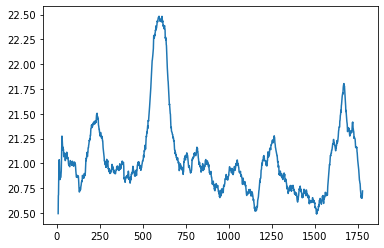

In [61]:
y = clinic_patient_log_df['time_in_system'].rolling(100, 10).mean()
plt.plot(y)

### Occupancy statistics

In addition to patient level metrics, we are interested in clinic level metrics such as the number of patients in each stage as this will impact space requirements. During the simulation, we collected occupancy data every time a patient entered or exited a stage. So, we need to do time weighted statistics.

In [62]:
postvac_occupancy_df = pd.read_csv('./output/postvac_occupancy_df.csv')
vac_occupancy_df = pd.read_csv('./output/vac_occupancy_df.csv')
postvac_occupancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3557 entries, 0 to 3556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ts      3557 non-null   float64
 1   occ     3557 non-null   float64
dtypes: float64(2)
memory usage: 55.7 KB


In [63]:
postvac_occupancy_df.iloc[250:275,]

,ts,occ
250,61.144806,40.0
251,61.351138,41.0
252,61.384551,40.0
253,61.485180,39.0
254,61.553590,40.0
255,61.640973,39.0
256,61.691657,40.0
257,61.754711,39.0
258,61.845740,40.0
259,62.015444,39.0


In order to make it easier to compute time averaged statistics, we will compute the amount of time between occupancy changes. These time durations will act as weights for computing time averaged statistics such as average occupancy. You cannot just do a simple average. 

In [64]:
# Compute difference between ts[i] i and ts[i + 1] 
# (in pandas this corresponds to periods=-1 in diff() function)
postvac_occupancy_df['occ_weight'] = -1 * postvac_occupancy_df['ts'].diff(periods=-1)
vac_occupancy_df['occ_weight'] = -1 * postvac_occupancy_df['ts'].diff(periods=-1)

# Need last occ_weight to compute weight for last row
last_weight = clinic_end_time - postvac_occupancy_df.iloc[-1, 0]
postvac_occupancy_df.fillna(last_weight, inplace=True)

last_weight = clinic_end_time - vac_occupancy_df.iloc[-1, 0]
vac_occupancy_df.fillna(last_weight, inplace=True)

In [65]:
np.average(a=postvac_occupancy_df['occ'], weights=postvac_occupancy_df['occ_weight'])

44.22093585099425

To make these ideas more concrete, just look at a few rows of the occupancy dataframe.

In [66]:
postvac_occupancy_df

,ts,occ,occ_weight
0,0.000000,0.0,4.780552
1,4.780552,1.0,0.177135
2,4.957687,2.0,0.232196
3,5.189882,3.0,0.179204
4,5.369087,4.0,0.436598
...,...,...,...
3552,619.324951,4.0,0.462171
3553,619.787122,3.0,1.081432
3554,620.868554,2.0,1.182041
3555,622.050595,1.0,1.019898


Let's plot the occupancy over time in the post-vaccination stage. The first plot is the entire day and the second just focuses on a small time slice so that we can see that these are discrete integer changes in occupancy.

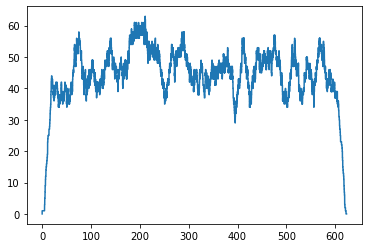

In [67]:
plt.step(postvac_occupancy_df['ts'], postvac_occupancy_df['occ'])

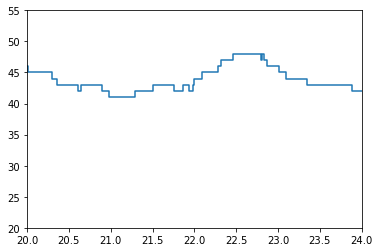

In [55]:
plt.step(postvac_occupancy_df['ts'], postvac_occupancy_df['occ'])
plt.xlim(20, 24)
plt.ylim(20, 55)
plt.show();

Now let's plot occupancy in the vaccination stage. Why does it look so different?

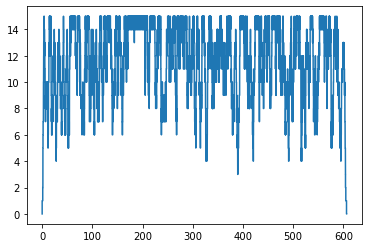

In [68]:
plt.step(vac_occupancy_df['ts'], vac_occupancy_df['occ'])

For capacitated resources, we are often interested in utilization. This is just the ratio of total occupancy to available capacity.

In [69]:
num_vaccinators = 15
available_capacity = clinic_end_time * num_vaccinators
available_capacity

9346.057389531847

In [70]:
used_capacity = clinic_patient_log_df['vaccination_time'].sum()

vaccinator_utilization = used_capacity / available_capacity

print(f"Vaccinator utilization: {vaccinator_utilization:0.3f}")

Vaccinator utilization: 0.760


To do things like weighted standard deviations or weighted quantiles, we can use the statsmodels package.

https://www.statsmodels.org/stable/generated/statsmodels.stats.weightstats.DescrStatsW.html

In [71]:
from statsmodels.stats.weightstats import DescrStatsW

In [72]:
# Create a weighted stats object
weighted_stats = DescrStatsW(postvac_occupancy_df['occ'], weights=postvac_occupancy_df['occ_weight'], ddof=0)

In [73]:
weighted_stats.mean

44.22093585099425

In [74]:
weighted_stats.std

9.395653520835333

In [75]:
weighted_stats.quantile([0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])

p
0.00     0.0
0.01     2.0
0.05    30.0
0.25    41.0
0.50    45.0
0.75    50.0
0.95    56.0
0.99    59.0
dtype: float64

If we want to minimize the "startup effect", we might throw out data for the first 100 patients.

In [76]:
# Create a weighted stats object after throwing out first 100 points
weighted_stats_gt100 = DescrStatsW(postvac_occupancy_df.iloc[100:, 1], weights=postvac_occupancy_df.iloc[100:, 2], ddof=0)

print(weighted_stats_gt100.mean)
print(weighted_stats_gt100.std)
occ_quantiles = weighted_stats_gt100.quantile([0, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
print(occ_quantiles)

45.22863098073956
7.772643383018959
p
0.00     0.5
0.01    13.0
0.05    35.0
0.25    41.0
0.50    46.0
0.75    50.0
0.95    57.0
0.99    59.0
dtype: float64


We can use these quantiles to create rough CDF and pdf plots of post-vaccination occupancy.

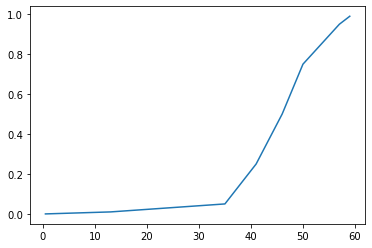

In [77]:
plt.plot(occ_quantiles, occ_quantiles.index);

In [78]:
probs = -1 * pd.Series(occ_quantiles.index).diff(-1)
probs.fillna(1.0 - sum(probs[:-1]), inplace=True)

In [79]:
probs

0    0.01
1    0.04
2    0.20
3    0.25
4    0.25
5    0.20
6    0.04
7    0.01
Name: p, dtype: float64

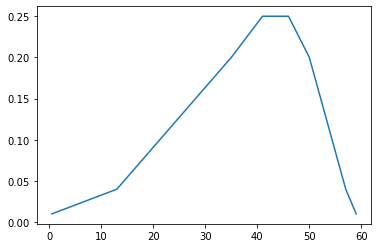

In [80]:
plt.plot(occ_quantiles, probs);

### Possible improvements

Now that we have a rough first model working, let's think about some possible improvements. There are many as we've taken numerous shortcuts to get this model working. We definitely want to make it easier to experiment with difference scenarios involving capacity levels and patient volume. A few potential improvements include:

* Specifying the global sim inputs through a command line interface (CLI)
* Getting rid of hard coded processing time distributions
* Having ability to choose between pure random walk-in arrivals and scheduled arrivals
* Multiple replications and/or steady state analysis

In the next notebook, we'll tackle some of these improvements.

## More SimPy resources
I suggest taking a look at some the following resources to get a sense of different ways of building SimPy models.

* [SimPy in 10 Minutes](https://simpy.readthedocs.io/en/latest/simpy_intro/index.html) - the "Hello, world" of SimPy
* [Example models from the SimPy documentation](https://simpy.readthedocs.io/en/latest/examples/index.html#all-examples) - demonstrates various features of SimPy through relatively simple models
* [SimPy: Simulating Real-World Processes With Python](https://realpython.com/simpy-simulating-with-python/) - a very good introductory tutorial
* [Getting started with SimPy for patient flow modeling ](http://hselab.org/simpy-getting-started-patient-flow-modeling.html) - one of my blog posts on SimPy modeling using a process focused approach
* [An object oriented SimPy patient flow simulation model ](http://hselab.org/simpy-first-oo-patflow-model.html) - one of my blog posts on SimPy modeling using an object oriented approach
* [Basic Network Simulations and Beyond in Python](https://www.grotto-networking.com/DiscreteEventPython.html#Intro) - good examples of network simulation models, building components to extend SimPy components. I found this site very helpful when I was building the patient flow models in the above two blog posts.